In [181]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [123]:
esg_data= pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/ESG_Data_Yearly.csv")
# esg_data.sort_values(by=['ESG Disc Score','Mkt Cap'],ascending=False,inplace=True)
year_group=esg_data.groupby(by='YEAR')

In [124]:
#Portfolio Creation using ESG
port_size = 50
port_stks_high_esg = pd.DataFrame()
port_stks_low_esg = pd.DataFrame()
for i in range(2010,2021):
    temp = year_group.get_group(i)
    temp.sort_values(by='ESG_DISC_SCORE',ascending=True,inplace=True)
    temp_len = len(temp)
    port_stks_high_esg[i] = [s for s in temp['ID'][temp_len-port_size:]]
    port_stks_low_esg[i] = [s for s in temp['ID'][:port_size]]



C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [125]:
# stocks we need the data for from the master STOCK_PRICE file. 
stks_needed_1 = [item for t in port_stks_high_esg.values.tolist() for item in t]
stks_needed_2 = [item for t in port_stks_low_esg.values.tolist() for item in t]
stks_needed = set(stks_needed_1).union(set(stks_needed_2))
stks_needed = list(stks_needed)
stks_needed = [i.replace(" US Equity","") for i in stks_needed]
# stks_needed
# pd.DataFrame(list(stks_needed)).to_csv("Stocks_needed.csv")

In [126]:
#Create the stock price database 
st_date = dt.datetime(2010,1,1)
en_date = dt.datetime(2020,12,31)
Stk_prices_list = []
flag = 0
tc_list = []
for tc in list(stks_needed):
    if flag ==0 : 
        flag =1 
        Stk_prices_list.append(yf.Ticker(tc).history(start=st_date,end=en_date).index)
        tc_list.append('Date')
    Stk_prices_list.append(yf.Ticker(tc).history(start=st_date,end=en_date)['Open'].tolist())
    tc_list.append(tc)

print(len(Stk_prices_list))
print(len(tc_list))
list_size = [len(i) for i in Stk_prices_list]
Stk_prices_list=list(map(list, itertools.zip_longest(*Stk_prices_list, fillvalue=None)))
Stock_prices = pd.DataFrame(Stk_prices_list,columns=tc_list)
# Stock_prices.fillna(method='ffill',inplace=True)
Stock_prices.set_index('Date',inplace=True)
# print(min(list_size))
# print(Stock_prices)
# Stock_prices.isna().sum(axis=0).sum()

#Create Database of stock prices
        

- LBTI: Data doesn't exist for startDate = 1262322000, endDate = 1609390800
- SHMP: Data doesn't exist for startDate = 1262322000, endDate = 1609390800
- GTHP: Data doesn't exist for startDate = 1262322000, endDate = 1609390800
- TUEM: Data doesn't exist for startDate = 1262322000, endDate = 1609390800
534
534


In [135]:
#read from Stock prices database
Stock_prices = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Stock_prices_Final.csv",index_col='Date')
Stock_prices.drop('Unnamed: 0',axis= 1,inplace=True)
Stock_prices.fillna(method='ffill',inplace=True)
Stock_prices.index = pd.to_datetime(Stock_prices.index)
Stock_returns = Stock_prices.pct_change()


251


In [142]:
#Caclulate the daily returns for ESG portfolios 
Dates = Stock_returns.index
Dates_len = len(Dates)
port_ret_high = []
port_ret_low = []

#initialize dataframe of len dates
# Loop over different portfolios and calcualte the daily returns for them 
toggle = 0
for port in [port_stks_high_esg,port_stks_low_esg]:
    for i in Dates[1:]:
        #debug conditoin
        if i.year == 2021:
            break
        temp = 0.0

        for j in port[i.year]:
            temp = temp + Stock_returns[j.replace(' US Equity','')][i] * 0.02
        
        if toggle == 0:
            port_ret_high.append(temp)
        else:
            port_ret_low.append(temp)
    toggle = 1
port_ret_high_esg = pd.DataFrame(port_ret_high,index=Dates[:len(Dates)-252],columns=['Returns'])
port_ret_low_esg = pd.DataFrame(port_ret_low,index=Dates[:len(Dates)-252],columns=['Returns'])


port_ret_high_esg.to_csv("Port_high_ret_daily.csv")
port_ret_low_esg.to_csv("Port_low_ret_daily.csv")


In [164]:
#Read FF factors 
ff_factors = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/Fama_French_Factors.csv",index_col="date",parse_dates=['date'])
ff_factors.head()

#Create a dataframe of fama frenchfactors and our returns 
mkt_rf = []
smb = []
hml = []
for i in port_ret_high_esg.index:
    mkt_rf.append(ff_factors['Mkt-RF'][i])
    smb.append(ff_factors['SMB'][i])
    hml.append(ff_factors['HML'][i])

fama_french_factors = pd.DataFrame(list(zip(mkt_rf,smb,hml)),columns=['MKT-RF',"SMB","HML"],index=port_ret_high_esg.index)



In [173]:
# Compare the returns to FF3 model and fit OLS model to it. 

#High ESG portfolio
X = sm.add_constant(fama_french_factors[['MKT-RF',"SMB","HML"]])
model1 = sm.OLS(port_ret_high_esg['Returns'],X).fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     372.9
Date:                Wed, 23 Mar 2022   Prob (F-statistic):          2.42e-203
Time:                        19:33:30   Log-Likelihood:                 8858.8
No. Observations:                2768   AIC:                        -1.771e+04
Df Residuals:                    2764   BIC:                        -1.769e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.959      0.050    -2.5e-07       0.001
MKT-RF         0.0028      0.000     16.100      0.000       0.002       0.003
SMB            0.0073      0.000     21.240      0.000       0.007       0.008
HML            0.0025      0.000      8.846      0.000       0.002       0.003
==============================================================================
Omnibus:                      872.830   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18706.598
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                      15.587   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
#Low ESG portfolio
model2 = sm.OLS(port_ret_low_esg['Returns'],X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.709
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           0.000682
Time:                        19:35:39   Log-Likelihood:                 4735.6
No. Observations:                2768   AIC:                            -9463.
Df Residuals:                    2764   BIC:                            -9439.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.001      5.939      0.000       0.003       0.007
MKT-RF         0.0015      0.001      1.898      0.058   -4.91e-05       0.003
SMB            0.0046      0.002      3.039      0.002       0.002       0.008
HML            0.0002      0.001      0.132      0.895      -0.002       0.003
==============================================================================
Omnibus:                     6646.264   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         78336955.663
Skew:                          24.033   Prob(JB):                         0.00
Kurtosis:                     825.746   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#TODO 
# 1. Create 3rd portfolio with buy high and sell low
# 2. Subtract risk free rate from final 
# 3. Incorporate momentum

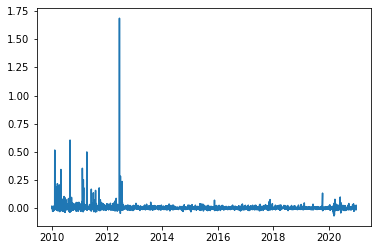

             Returns  Cum_Rets
Date                          
2010-01-04  0.005408  1.005408
2010-01-05  0.018687  1.018687
2010-01-06  0.012718  1.012718
2010-01-07 -0.006550  0.993450
2010-01-08  0.004161  1.004161
...              ...       ...
2020-12-23  0.012905  1.012905
2020-12-24 -0.009300  0.990700
2020-12-28 -0.005556  0.994444
2020-12-29 -0.016075  0.983925
2020-12-30  0.024011  1.024011

[2768 rows x 2 columns]


In [207]:
port_ret_high_esg["Cum_Rets"] = port_ret_high_esg["Returns"]+1
port_ret_low_esg["Cum_Rets"] = port_ret_low_esg["Returns"]+1
cum_rets_high_esg = port_ret_high_esg["Cum_Rets"].cumprod()
cum_rets_low_esg = port_ret_low_esg["Cum_Rets"].cumprod()

# plt.plot(cum_rets_high_esg)
# plt.plot(cum_rets_low_esg)
plt.plot(port_ret_low_esg['Returns'])
plt.show()
min(port_ret_low_esg['Returns'])
print(port_ret_low_esg)